# Libray matching with DreaMS

## Introduction

According to the results presented in our [paper]((https://chemrxiv.org/engage/chemrxiv/article-details/6626775021291e5d1d61967f)), DreaMS embeddings provide a more accurate way to perform library matching than traditional algorithms such as modified cosine similarity or spectral entropy. Library matching is the annotation of a query spectrum with a molecule corresponding to the most similar spectrum in some given spectral library. In this tutorial, we will demonstrate how to perform library matching with DreaMS embeddings using the [MassSpecGym](https://github.com/MassSpecGym/MassSpecGym) dataset as a library, which contains a curated collection of public high-quality MS/MS spectra.

Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from rdkit import Chem
import dreams.utils.spectra as su
import dreams.utils.io as io
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.api import dreams_embeddings
from dreams.definitions import *
%reload_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Load data

Load example dataset downloaded from [MSV000086206](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=11fbd0d4c9144a6c813b196d865567ab) and [MassSpecGym library with pre-computed DreaMS embeddings]().

In [2]:
in_pth = Path('../data/S_N1.mzML')  # Example dataset
lib_pth = Path('../data/MassSpecGym_DreaMS.hdf5')  # MassSpecGym library

In [3]:
msdata_lib = MSData.load(lib_pth)
embs_lib = msdata_lib[DREAMS_EMBEDDING]
print('Shape of the library embeddings:', embs_lib.shape)

Shape of the library embeddings: (213548, 1024)


In [4]:
msdata = MSData.load(in_pth)
embs = dreams_embeddings(msdata)
print('Shape of the query embeddings:', embs.shape)

Computing DreaMS embedding: 100%|██████████| 3809/3809 [01:35<00:00, 39.86it/s]


Shape of the query embeddings: (3809, 1024)


## Perform library matching

Compute all cosine similarity between the query and library DreaMS embeddings.

In [5]:
sims = cosine_similarity(embs, embs_lib)
sims.shape

(3809, 213548)

Choose top-k candidates with the highest similarity per query spectrum.

In [6]:
k = 5
topk_cands = np.argsort(sims, axis=1)[:, -k:][:, ::-1]
topk_cands.shape

(3809, 5)

Organize the results in a DataFrame with the most important library metadata, such as library SMILES.

In [8]:
# Construct a DataFrame with the top-k candidates for each spectrum and their corresponding similarities
df = []
cos_sim = su.PeakListModifiedCosine()
for i, topk in enumerate(tqdm(topk_cands)):
    for n, j in enumerate(topk):
        df.append({
            'feature_id': i + 1,
            'topk': n + 1,
            'library_j': j,
            'library_SMILES': msdata_lib.get_smiles(j),
            'library_ID': msdata_lib.get_values('IDENTIFIER', j),
            'DreaMS_similarity': sims[i, j],
            'Modified_cosine_similarity': cos_sim(
                spec1=msdata.get_spectra(i),
                prec_mz1=msdata.get_prec_mzs(i),
                spec2=msdata_lib.get_spectra(j),
                prec_mz2=msdata_lib.get_prec_mzs(j),
            ),
            'i': i,
            'j': j,
        })
df = pd.DataFrame(df)

# Sort hits by DreaMS similarity
df_top1 = df[df['topk'] == 1].sort_values('DreaMS_similarity', ascending=False)
df = df.set_index('feature_id').loc[df_top1['feature_id'].values].reset_index()
df

100%|██████████| 3809/3809 [00:22<00:00, 168.11it/s]


,feature_id,topk,library_j,library_SMILES,library_ID,DreaMS_similarity,Modified_cosine_similarity,i,j
0,344,1,200338,CC(=O)N(CCCC[C@@H](C(=O)O)NC(=O)CC(CC(=O)N[C@@...,MassSpecGymID0396609,0.979676,0.999883,343,200338
1,344,2,150587,CN1C2=C(C=CC(=C2)C3=CC=C(C=C3)C[C@@H](C#N)NC(=...,MassSpecGymID0231755,0.601104,0.488964,343,150587
2,344,3,146017,CC(=O)NCCCOC1=CC=C(C=C1)C(=O)N2CCC(CC2)N3C(=O)...,MassSpecGymID0225137,0.570049,0.725630,343,146017
3,344,4,133810,C1COCCN1CC(=O)N2C(CC(=N2)C3=CC(=CC=C3)F)C4=CC=CS4,MassSpecGymID0209304,0.557548,0.726254,343,133810
4,344,5,146016,CC(=O)NCCCOC1=CC=C(C=C1)C(=O)N2CCC(CC2)N3C(=O)...,MassSpecGymID0225136,0.554845,0.725409,343,146016
...,...,...,...,...,...,...,...,...,...
19040,1789,1,100792,CC(=CCOC1=C2C=CC(=O)OC2=CC3=C1C=CO3)C,MassSpecGymID0151614,0.342242,0.831349,1788,100792
19041,1789,2,168904,CC1=C(N2C(C(C2=O)[NH3+])SC1)C(=O)[O-],MassSpecGymID0268406,0.328011,0.700030,1788,168904
19042,1789,3,168906,CC1=C(N2C(C(C2=O)[NH3+])SC1)C(=O)[O-],MassSpecGymID0268414,0.327554,0.809387,1788,168906
19043,1789,4,100800,CC(=CCOC1=C2C=CC(=O)OC2=CC3=C1C=CO3)C,MassSpecGymID0151624,0.327202,0.737573,1788,100800


Store results to CSV file.

In [9]:
df.to_csv(io.append_to_stem(in_pth, 'MassSpecGym_hits').with_suffix('.csv'), index=False)

## Library matching results

Let's look at the retrieved library spectra for our query spectra. First, let's look at the confidently matched spectrum with a high DreaMS similarity.

Library ID: MassSpecGymID0236163 (top 1 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.8856791853904724
Modified cosine similarity: 0.9892408193123613


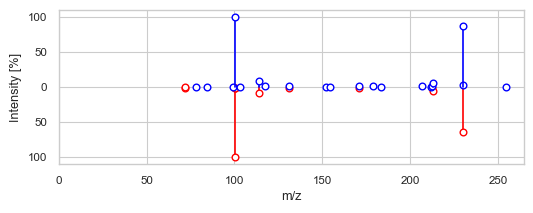

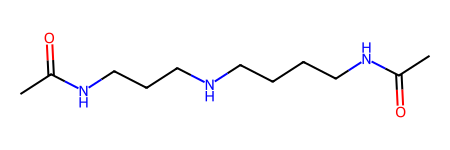

Library ID: MassSpecGymID0236162 (top 2 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.8603853583335876
Modified cosine similarity: 0.7990432320842271


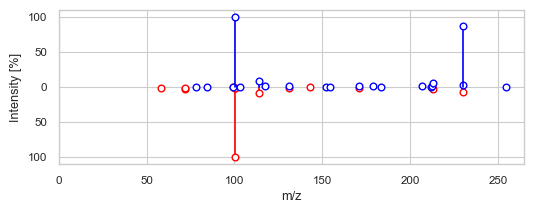

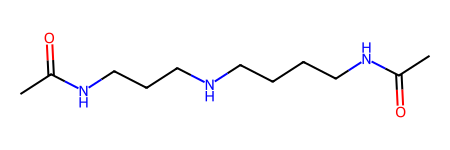

Library ID: MassSpecGymID0236161 (top 3 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.7787462472915649
Modified cosine similarity: 0.716395852717653


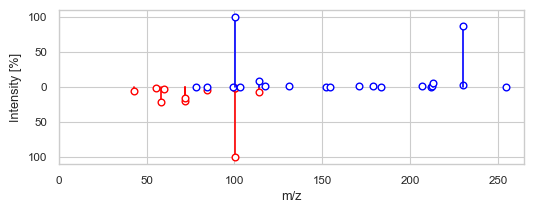

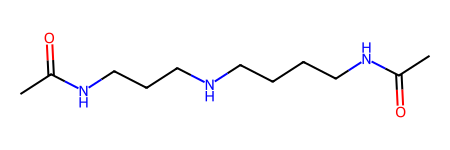

Library ID: MassSpecGymID0391831 (top 4 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.223
DreaMS similarity: 0.6461858749389648
Modified cosine similarity: 0.1537209674611311


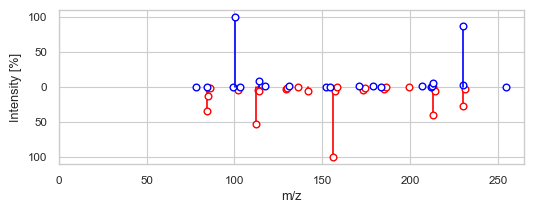

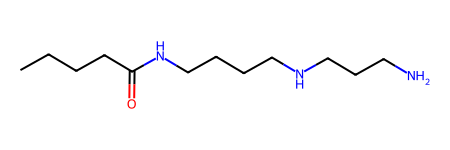

Library ID: MassSpecGymID0391832 (top 5 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.223
DreaMS similarity: 0.6406431198120117
Modified cosine similarity: 0.09253357021617656


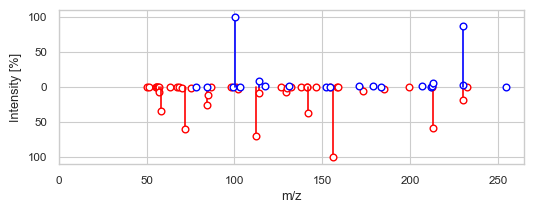

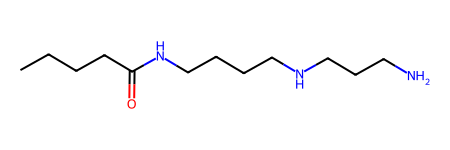

In [26]:
i = df_top1['i'].iloc[25]
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

The top-1 hit demonstrates a strong match, aligning well with the modified cosine similarity. However, annotating a query spectrum with a library spectrum is often impossible due to the limited size of available libraries. In such instances, DreaMS similarity offers an interesting approach, providing insights into the molecular structure even without a definitive match. Let's examine a case with a less confident hit to illustrate this concept.

Library ID: MassSpecGymID0158953 (top 1 hit)
Query precursor m/z: 531.239929199219, Library precursor m/z: 465.1603
DreaMS similarity: 0.5554009079933167
Modified cosine similarity: 0.10728813770443299


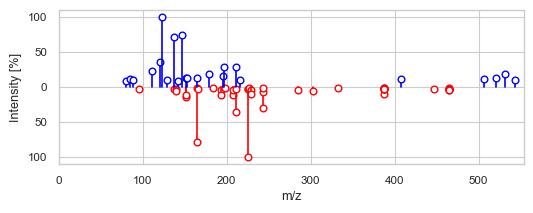

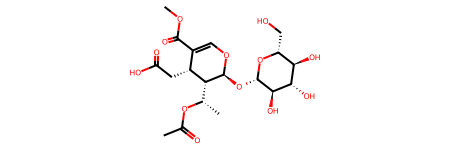

Library ID: MassSpecGymID0149523 (top 2 hit)
Query precursor m/z: 531.239929199219, Library precursor m/z: 513.1603
DreaMS similarity: 0.5552796125411987
Modified cosine similarity: 0.18206195952752596


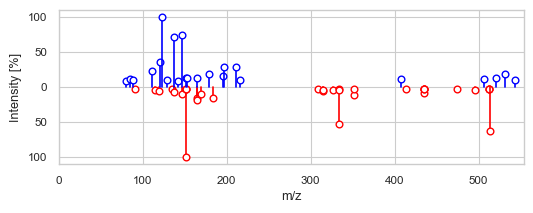

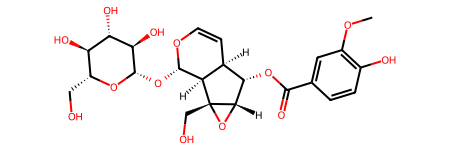

Library ID: MassSpecGymID0149526 (top 3 hit)
Query precursor m/z: 531.239929199219, Library precursor m/z: 513.1603
DreaMS similarity: 0.5552796125411987
Modified cosine similarity: 0.18206195952752596


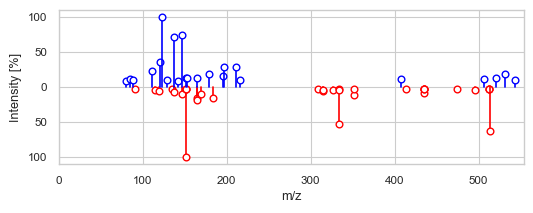

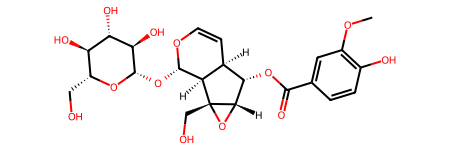

Library ID: MassSpecGymID0156224 (top 4 hit)
Query precursor m/z: 531.239929199219, Library precursor m/z: 433.221
DreaMS similarity: 0.5525350570678711
Modified cosine similarity: 0.34787377644067274


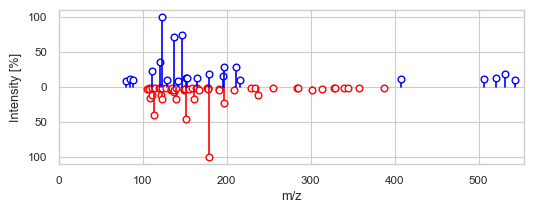

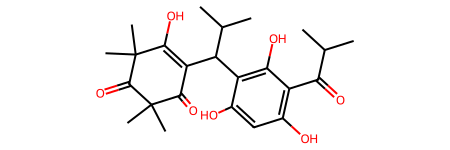

Library ID: MassSpecGymID0192634 (top 5 hit)
Query precursor m/z: 531.239929199219, Library precursor m/z: 543.17083
DreaMS similarity: 0.545224130153656
Modified cosine similarity: 0.19979507203032698


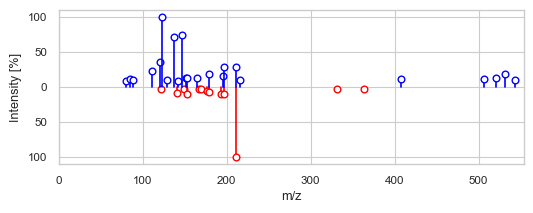

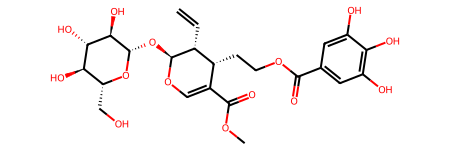

In [53]:
i = df_top1['i'].iloc[-1555]
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

While the query spectrum cannot be confidently matched with any known library spectrum, examining the top-5 hits reveals a pattern. The retrieved molecules share, to a certain extent, similar structures, predominantly being carbohydrates and containing sugar moieties, suggesting the features of the unknown compound represented by a query spectrum. This observation suggests that even without a definitive match, we can make a hypothesis about the structure of the unknown compound.

## Even faster search via approximate nearest neighbors

To achieve even faster library matching, we can use the approach of approximate nearest neighbors (ANN). In this example, we'll utilize the [PyNNDescent](https://pynndescent.readthedocs.io/en/latest/index.html) library. However, since DreaMS embeddings are 1024-dimensional vectors, they can be seamlessly integrated with any other vector database of your choice for efficient similarity search or other applications (e.g., clustering or visualization).

In [55]:
# Build an index for the library
import pynndescent
index = pynndescent.NNDescent(embs_lib, metric='cosine', n_neighbors=50)

In [56]:
# Approximate nearest neighbors search fir i-th spectrum
neighbors = index.query(embs[[i]])
pd.DataFrame({
    'j': neighbors[0][0],
    'DreaMS_similarity': 1 - neighbors[1][0]  # Convert distances to similarities
})

,j,DreaMS_similarity
0,104515,0.555401
1,99464,0.555280
2,99467,0.555280
3,103169,0.552535
4,123609,0.545224
5,107589,0.522583
6,104514,0.520798
7,123608,0.520051
8,123014,0.514094
9,170589,0.513779


In [57]:
# Exact nearest neighbors search for i-th spectrum
df_i[['j', 'DreaMS_similarity']]

,j,DreaMS_similarity
11270,104515,0.555401
11271,99464,0.555280
11272,99467,0.555280
11273,103169,0.552535
11274,123609,0.545224


As we can see, the result of the ANN search is identical to the exact nearest neighbors search. However, the ANN search is much faster, especially for large libraries.